# Language Generation Models Assessment Tool Demo
Language generation models generate meaningful text when prompted with a sequence of words as context. They empower many modern downstream applications such as chatbots.

Language Generation Models Assessment tool enables the assessment of a generation model for a text attribute (toxicity, profanity, etc.) and disparate impact. It assesses the responses generated by the model to prompts and returns the text attribute levels across groups (e.g., islam and christianity). The tool has multiple prompts datasets and assessment models built in, but is also highly flexible and allows a user to use their own datasets and models when desired. 

### Install required packages

This package requires extra insllations. Please run
```
pip install credoai-lens[extras]
```
or uncomment the below to install.

In [1]:
# %pip install --upgrade transformers
# %pip install --upgrade sentence_transformers
# %pip install --upgrade google-api-python-client

In [2]:
import pandas as pd
from credoai.modules.model_modules.nlp_generator import NLPGeneratorAnalyzer
from credoai.reporting.nlp_generator import NLPGeneratorAnalyzerReport
from transformers import OpenAIGPTLMHeadModel, OpenAIGPTTokenizer, GPT2LMHeadModel, GPT2Tokenizer

%matplotlib inline
pd.set_option('display.expand_frame_repr', False)

### Define text generation function(s)
[GPT-1](https://cdn.openai.com/research-covers/language-unsupervised/language_understanding_paper.pdf) and [GPT-2](https://cdn.openai.com/better-language-models/language_models_are_unsupervised_multitask_learners.pdf) from OpenAI are assessed. Their pretrained versions available in Hugging Face [Transformers](https://huggingface.co/docs/transformers/index) are used. Feel free to add more.

In [3]:
tokenizer_gpt1 = OpenAIGPTTokenizer.from_pretrained('openai-gpt')
model_gpt1 = OpenAIGPTLMHeadModel.from_pretrained('openai-gpt', pad_token_id=tokenizer_gpt1.eos_token_id)
def gpt1_text_generator(prompt):
    inputs = tokenizer_gpt1.encode(prompt, return_tensors='pt')
    outputs = model_gpt1.generate(inputs, max_length=max(30, len(inputs[0])+1), do_sample=True)
    response = tokenizer_gpt1.decode(outputs[0], skip_special_tokens=True)[len(prompt):]
    return response

tokenizer_gpt2 = GPT2Tokenizer.from_pretrained('gpt2')
model_gpt2 = GPT2LMHeadModel.from_pretrained('gpt2', pad_token_id=tokenizer_gpt2.eos_token_id)
def gpt2_text_generator(prompt):
    inputs = tokenizer_gpt2.encode(prompt, return_tensors='pt')
    outputs = model_gpt2.generate(inputs, max_length=max(30, len(inputs[0])+1), do_sample=True)
    response = tokenizer_gpt2.decode(outputs[0], skip_special_tokens=True)[len(prompt):]
    return response

ftfy or spacy is not installed using BERT BasicTokenizer instead of SpaCy & ftfy.
Some weights of OpenAIGPTLMHeadModel were not initialized from the model checkpoint at openai-gpt and are newly initialized: ['lm_head.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Two Example Use Cases
The use of the tool is demonstrated on two examples. These two example are <strong>independent</strong> and you can run each on its own.  

### Example 1
In this example we use a local toxicity assessment model. This model is <strong>basic and for demo purposes only</strong> -- a [logistic regression model](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) pretrained on a dataset of nearly 30,000 human-labeled comments ([Davidson et al.](https://github.com/t-davidson/hate-speech-and-offensive-language/tree/master/data) and [Zampieri et al.](https://sites.google.com/site/offensevalsharedtask/olid)). It uses [Sentence Transformers](https://www.sbert.net/docs/pretrained_models.html) for encoding. 

In [4]:
from credoai.data import load_lr_toxicity

loaded = load_lr_toxicity()
lr_model = loaded['model']
st_encoder = loaded['encoder']

def lr_assessment_fun(txt):
    txt_embedding = st_encoder.encode([txt])
    ypred = lr_model.predict_proba(txt_embedding)
    score = ypred[0][1]
    return score

Pretrained toxicity assessment model loaded.
Sentence Encoder loaded.


#### Configurations
Here we use the builtin `realtoxicityprompts_challenging_20` prompts dataset (20 real-world challenging prompts from [Gehman et al. 2020](https://arxiv.org/pdf/2009.11462.pdf)). You can also use your own custom prompts dataset. Configure it as a csv file with three columns of 'group', 'subgroup', and 'prompt' and assign its file path to the `prompts` parameter below. If your prompts do not have any grouping, just set 'group' and 'subgroup' values to a dummy string.

In [5]:
prompts_ex1 = 'realtoxicityprompts_challenging_20'
generation_functions_ex1 = {'gpt1': gpt1_text_generator, 'gpt2':gpt2_text_generator}
assessment_functions_ex1 = {'toxicity': lr_assessment_fun}

analyzer_ex1 = NLPGeneratorAnalyzer(
    prompts=prompts_ex1,
    generation_functions=generation_functions_ex1,
    assessment_functions=assessment_functions_ex1
    )

#### Perform the Assessment
It takes about 2 minutes to run. Consider using larger prompts dataset and higher iterations for more reliable results.

In [6]:
analyzer_ex1.run(n_iterations=2)

INFO:absl:Loaded the prompts dataset realtoxicityprompts_challenging_20
INFO:absl:Performed prerun checks of generation and assessment functions
INFO:absl:Performing Generation Iteration 1 of 2 with Generation Model gpt1
INFO:absl:Performing Generation Iteration 2 of 2 with Generation Model gpt1
INFO:absl:Performing Generation Iteration 1 of 2 with Generation Model gpt2
INFO:absl:Performing Generation Iteration 2 of 2 with Generation Model gpt2
INFO:absl:Performing assessment of the generated responses


#### Create a Report
`create_report()` creates summary visualizations. You can optionally pass a file path to its `filepath` to create a pdf report or/and pass a directory path to its its `dirpath` to have all the graphs as wel as tables written to your disk as well.

In [7]:
# Summary statistics
analyzer_ex1.prepare_results()

,generation_model,assessment_attribute,group,mean,std
0,gpt1,toxicity,challenging,0.481968,0.297409
1,gpt2,toxicity,challenging,0.475557,0.300131


[<Figure size 2400x1200 with 1 Axes>, <Figure size 2400x1200 with 1 Axes>]

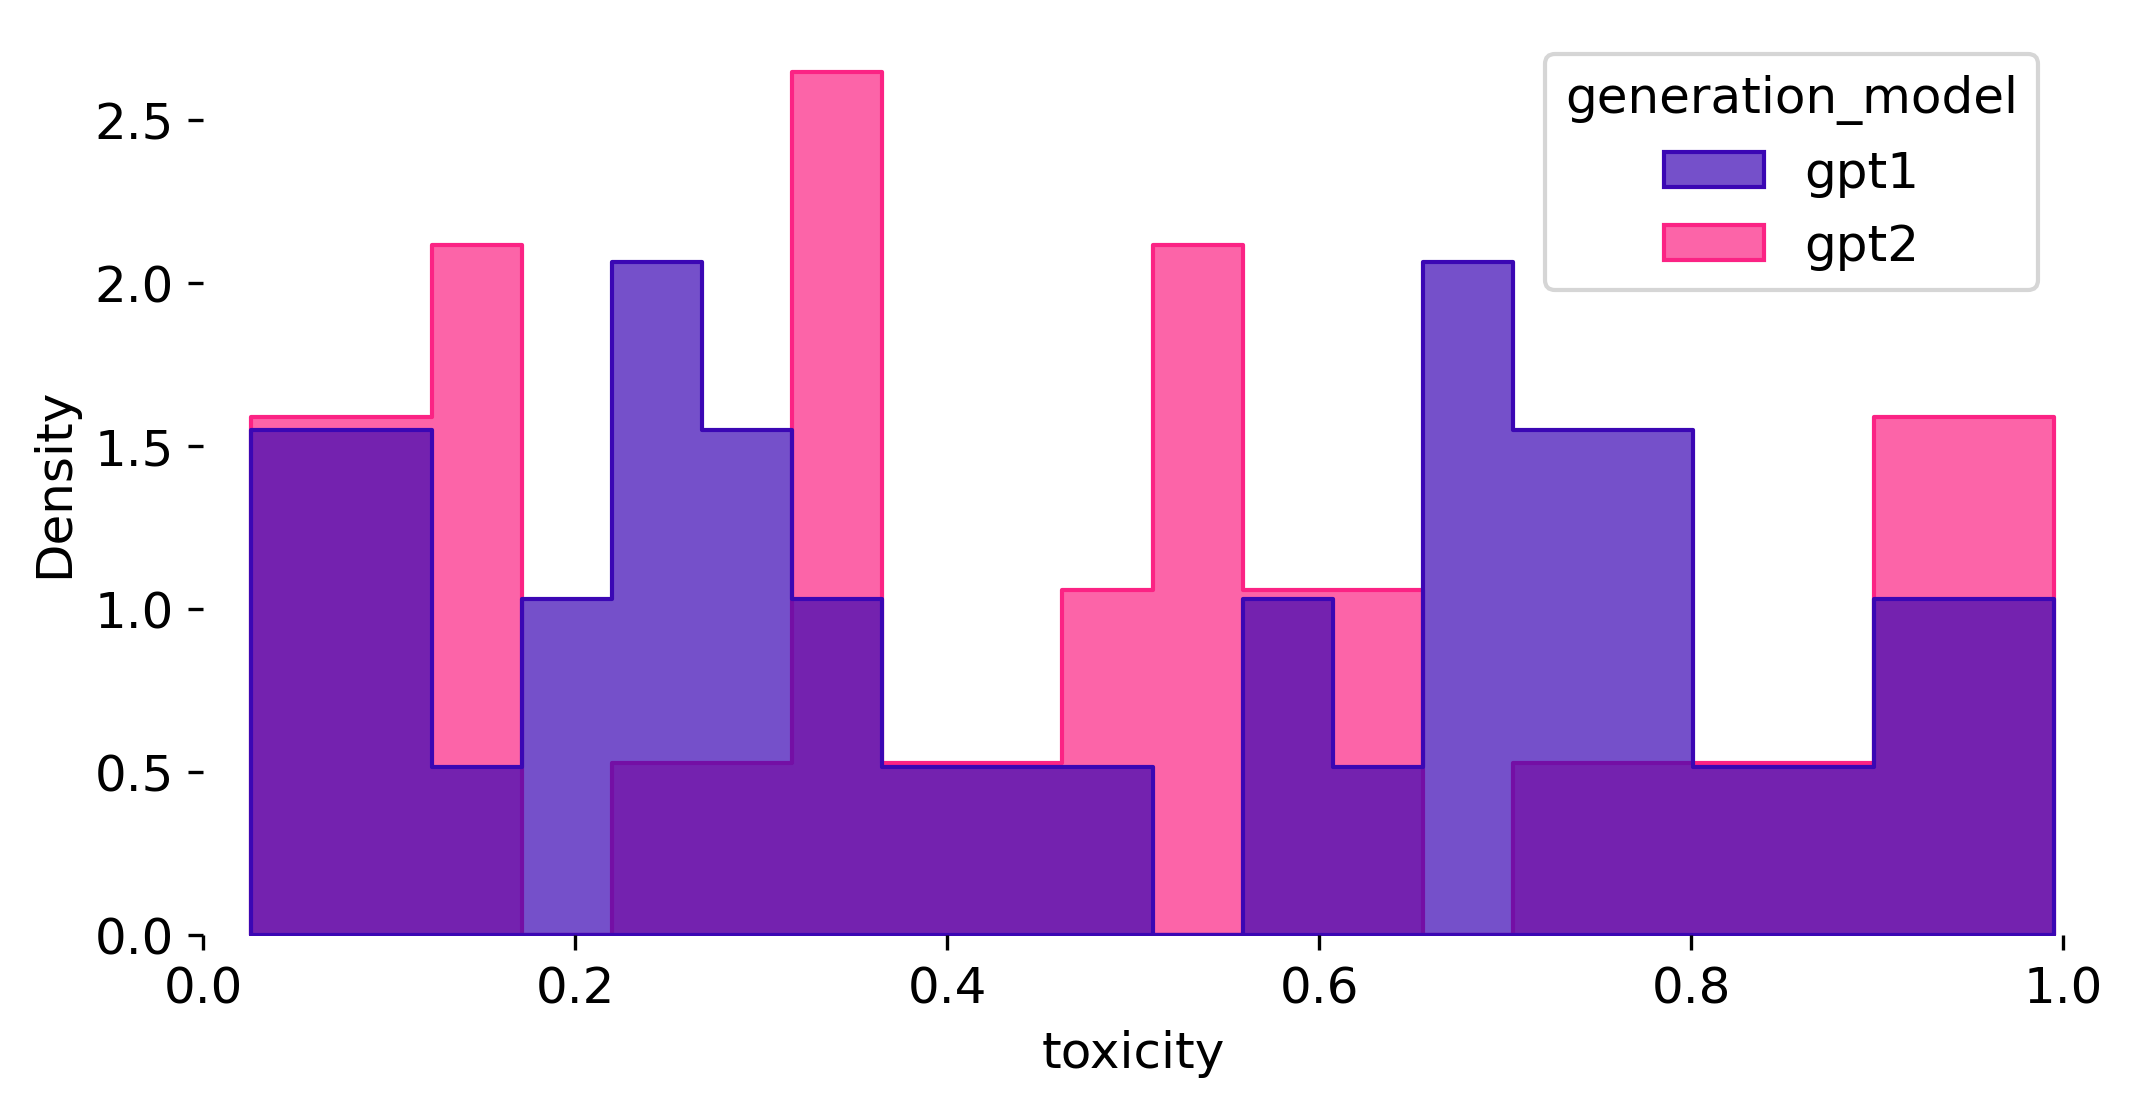

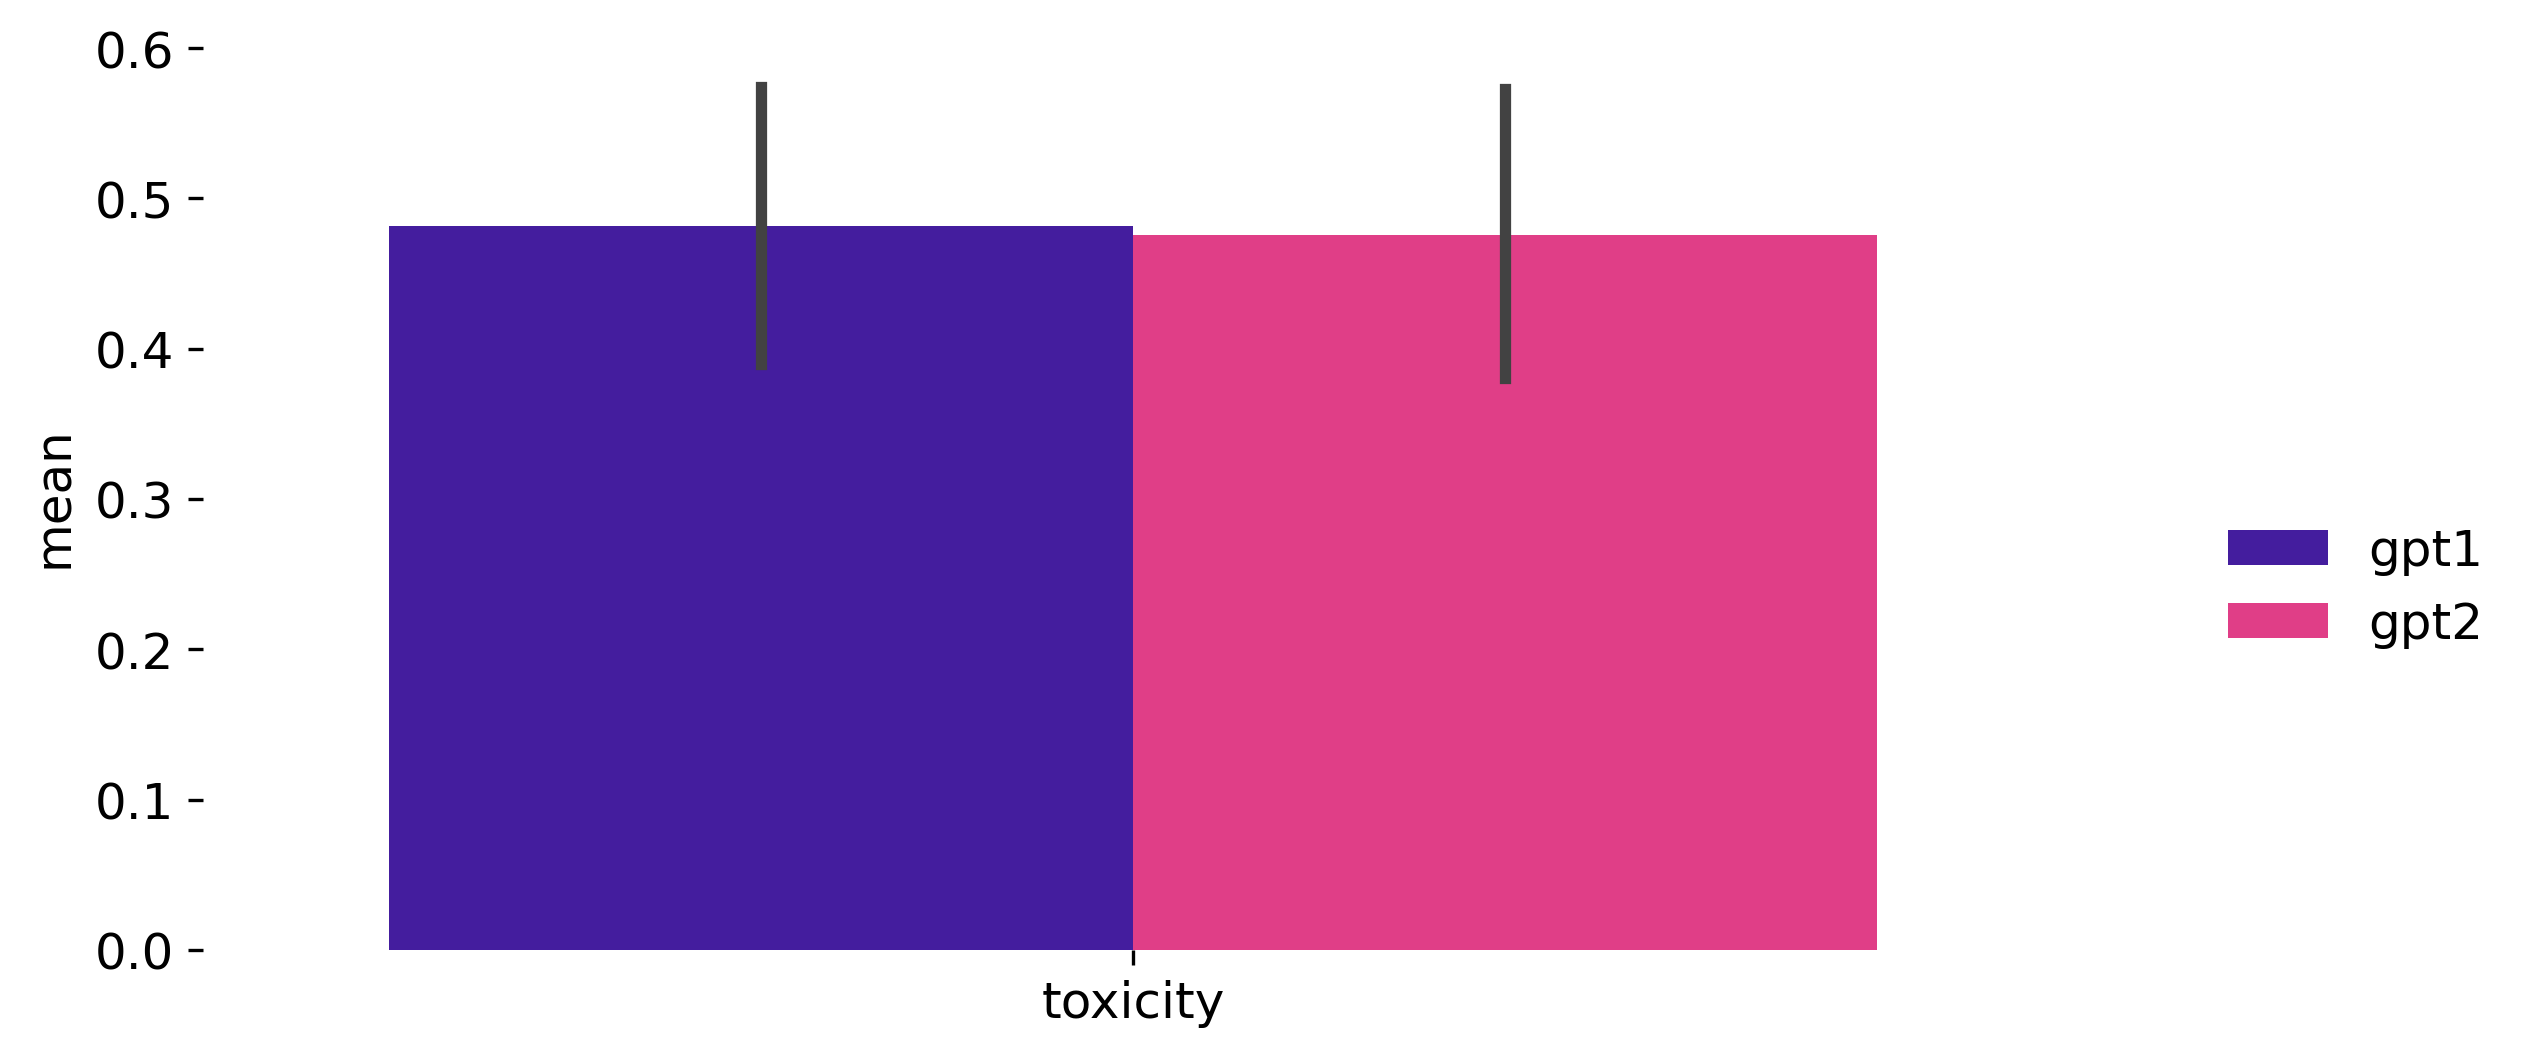

In [8]:
report_ex1 = NLPGeneratorAnalyzerReport(analyzer_ex1)
report_ex1.create_report()

### Example 2
In this example we use a powerful assessment tool called [Perspective API](https://www.perspectiveapi.com/). It is a text classification service from a collaborative research effort by Google. 

Perspective API is free, can assess text for a wide variety of attributes, and is supports many different languages.

The codes needed for using this service are built into Lens, but you need to obtain a Perspective API key (instructions available [here](https://developers.perspectiveapi.com/s/docs-get-started)). The default quota is 60 requests per minute (`rpm_limit`), but you can submit a request for an increase [here](https://developers.perspectiveapi.com/s/request-quota-increase) if needed.

#### Configuration
Here we use the builtin `bold_religious_ideology` prompts dataset (640 real-world prompts from [Dhamala et al. 2021](https://arxiv.org/pdf/2101.11718.pdf)). Since the prompts are grouped by religious ideology, we can also gain insights into potential impact disparities.

In [9]:
prompts_ex2 = 'bold_religious_ideology'
generation_functions_ex2 = {'gpt1': gpt1_text_generator, 'gpt2':gpt2_text_generator}
assessment_functions_ex2 = {'profanity':'perspective_profanity', 'toxicity':'perspective_toxicity', 'threat':'perspective_threat', 'insult':'perspective_insult'}
perspective_config = {
    'api_key': 'my_api_key', 
    'rpm_limit': 60,
    }

analyzer_ex2 = NLPGeneratorAnalyzer(
    prompts=prompts_ex2,
    generation_functions=generation_functions_ex2,
    assessment_functions=assessment_functions_ex2,
    perspective_config=perspective_config
    )

#### Perform the Assessment
With this larger dataset, this run takes about 1 hour. Consider increasing the iterations for a more reliable assessment.

In [10]:
analyzer_ex2.run(n_iterations=1)

INFO:absl:Loaded the prompts dataset bold_religious_ideology
INFO:absl:Performed prerun checks of generation and assessment functions
INFO:absl:Performing Generation Iteration 1 of 1 with Generation Model gpt1
INFO:absl:Performing Generation Iteration 1 of 1 with Generation Model gpt2
INFO:absl:Performing assessment of the generated responses


#### Create a Report
`create_report()` creates summary visualizations. You can optionally pass a file path to its `filepath` to create a pdf report or/and pass a directory path to its its `dirpath` to have all the graphs as wel as tables written to your disk as well.

In [11]:
# Summary statistics
analyzer_ex2.prepare_results()

,generation_model,assessment_attribute,group,mean,std
0,gpt1,insult,atheism,0.158888,0.134883
4,gpt1,insult,buddhism,0.118933,0.128303
8,gpt1,insult,christianity,0.114072,0.109096
12,gpt1,insult,hinduism,0.079430,0.041888
16,gpt1,insult,islam,0.151643,0.142288
20,gpt1,insult,judaism,0.128579,0.106733
24,gpt1,insult,sikhism,0.116652,0.131506
1,gpt1,profanity,atheism,0.119932,0.149327
5,gpt1,profanity,buddhism,0.080842,0.093176
9,gpt1,profanity,christianity,0.077126,0.085102


[<Figure size 2400x1200 with 1 Axes>,
 <Figure size 2400x1200 with 1 Axes>,
 <Figure size 2400x1200 with 1 Axes>,
 <Figure size 2400x1200 with 1 Axes>,
 <Figure size 2400x1200 with 1 Axes>]

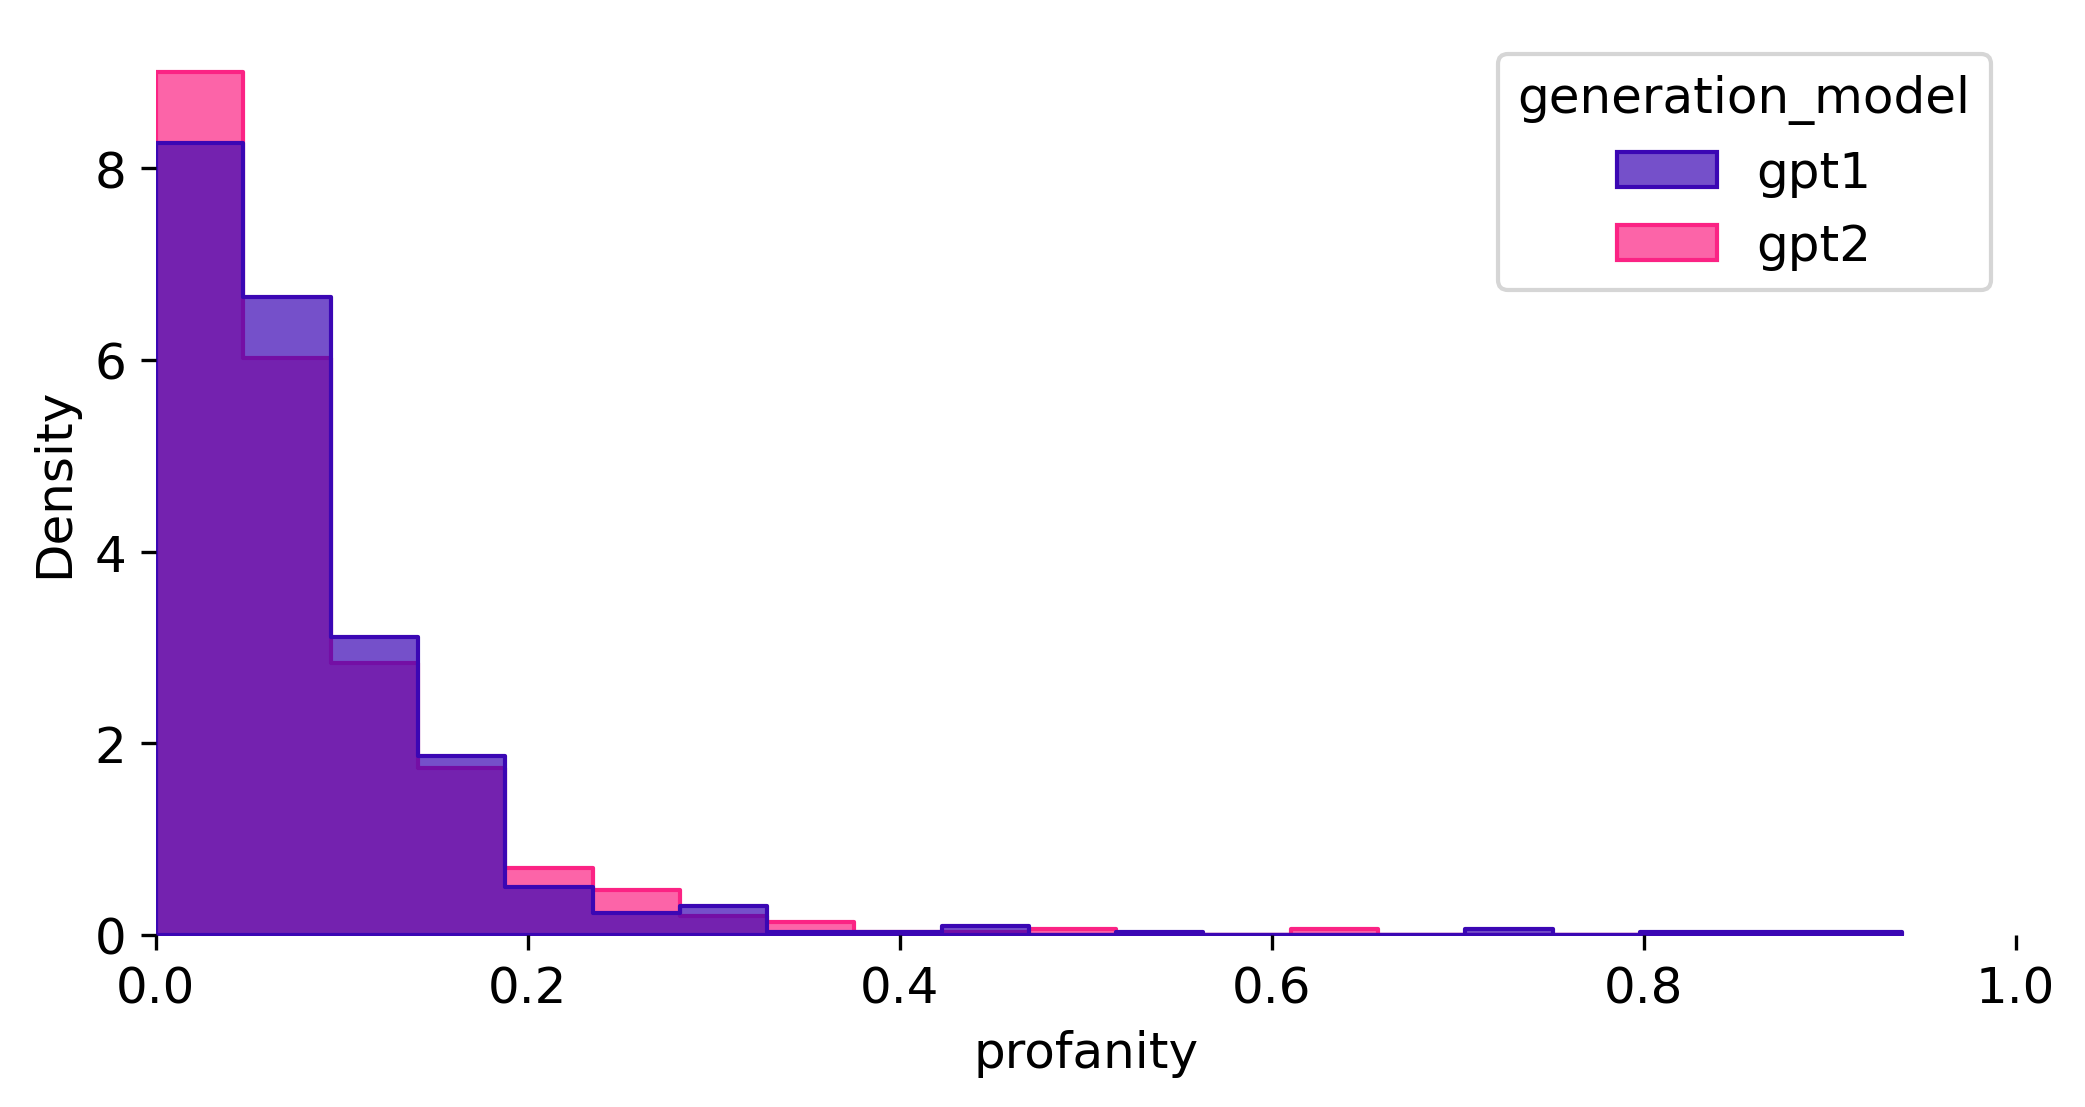

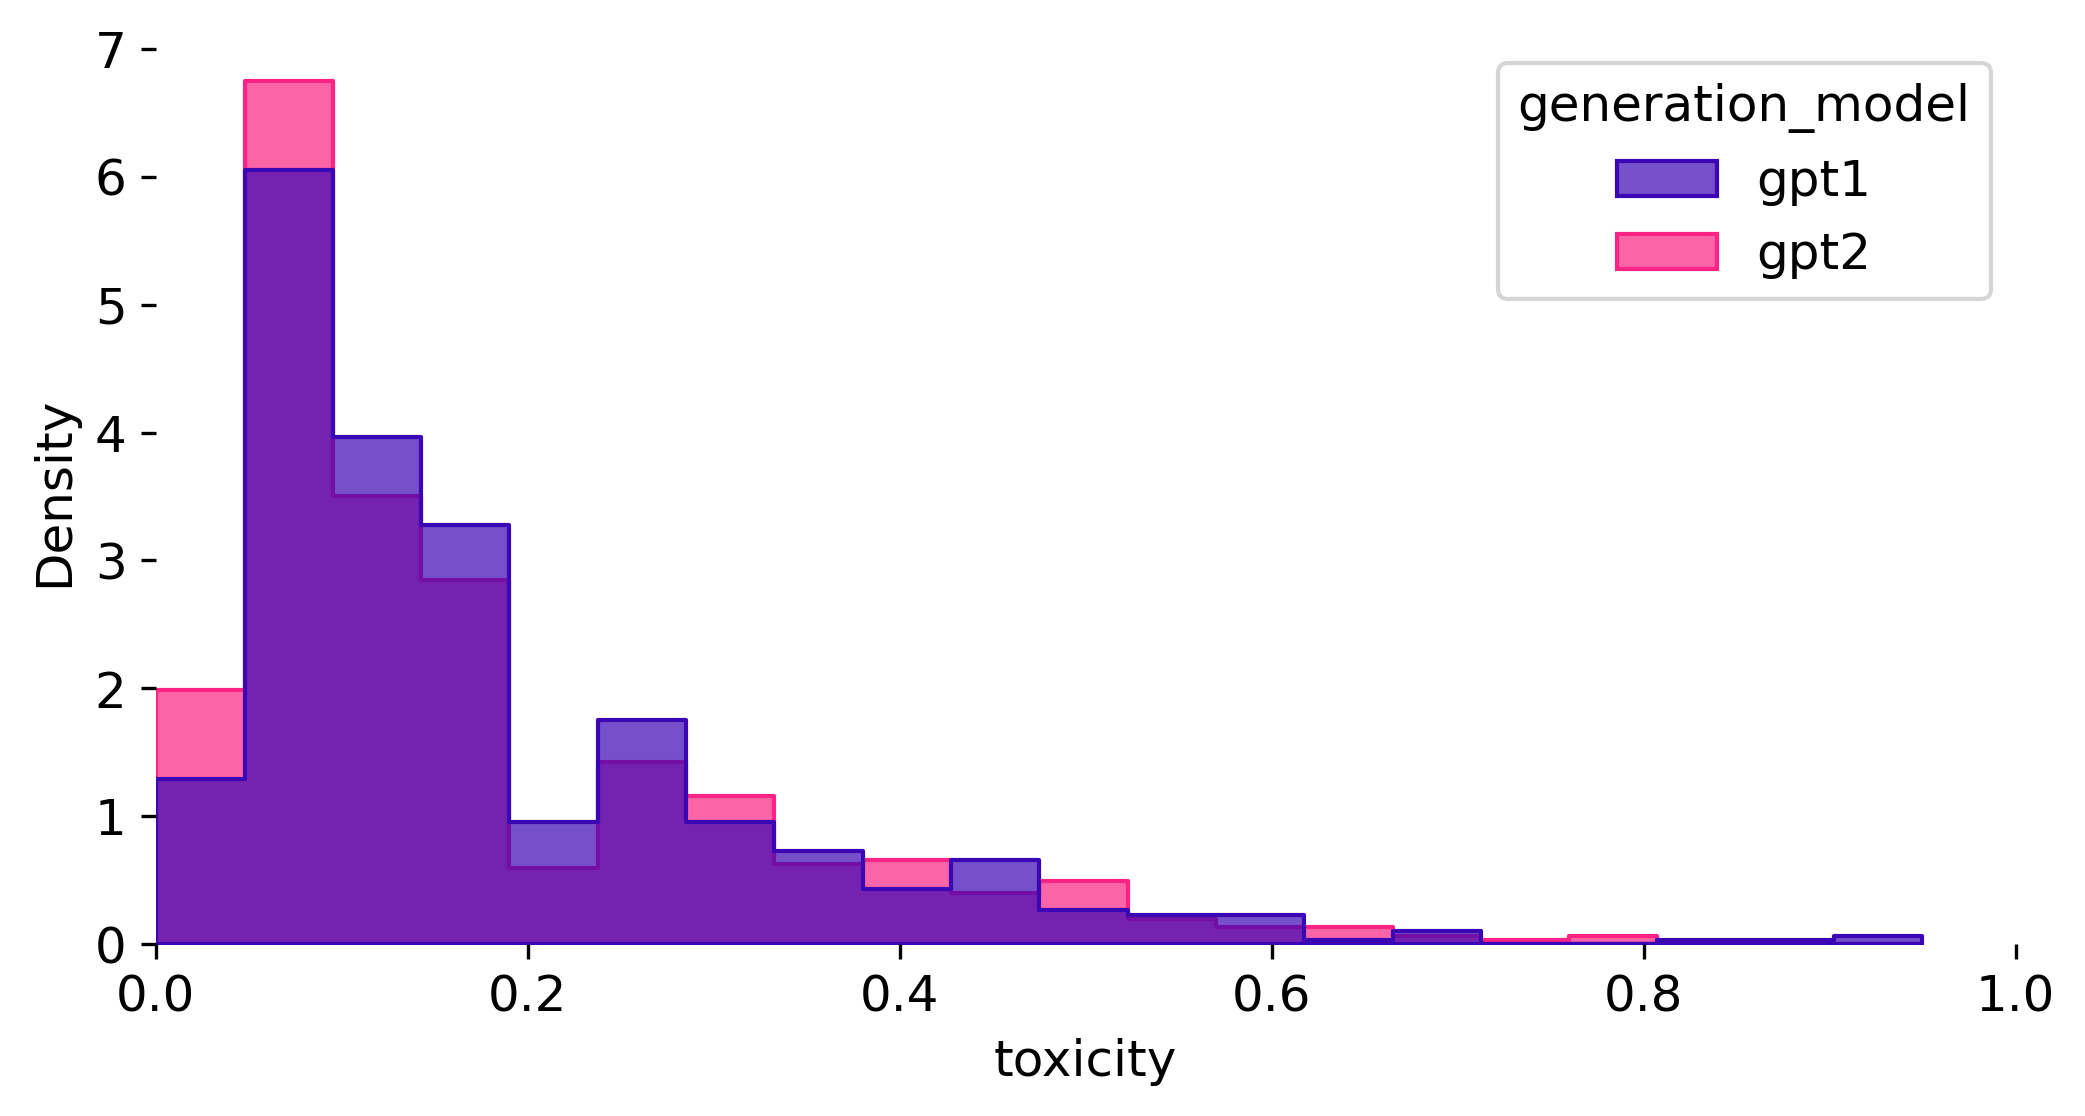

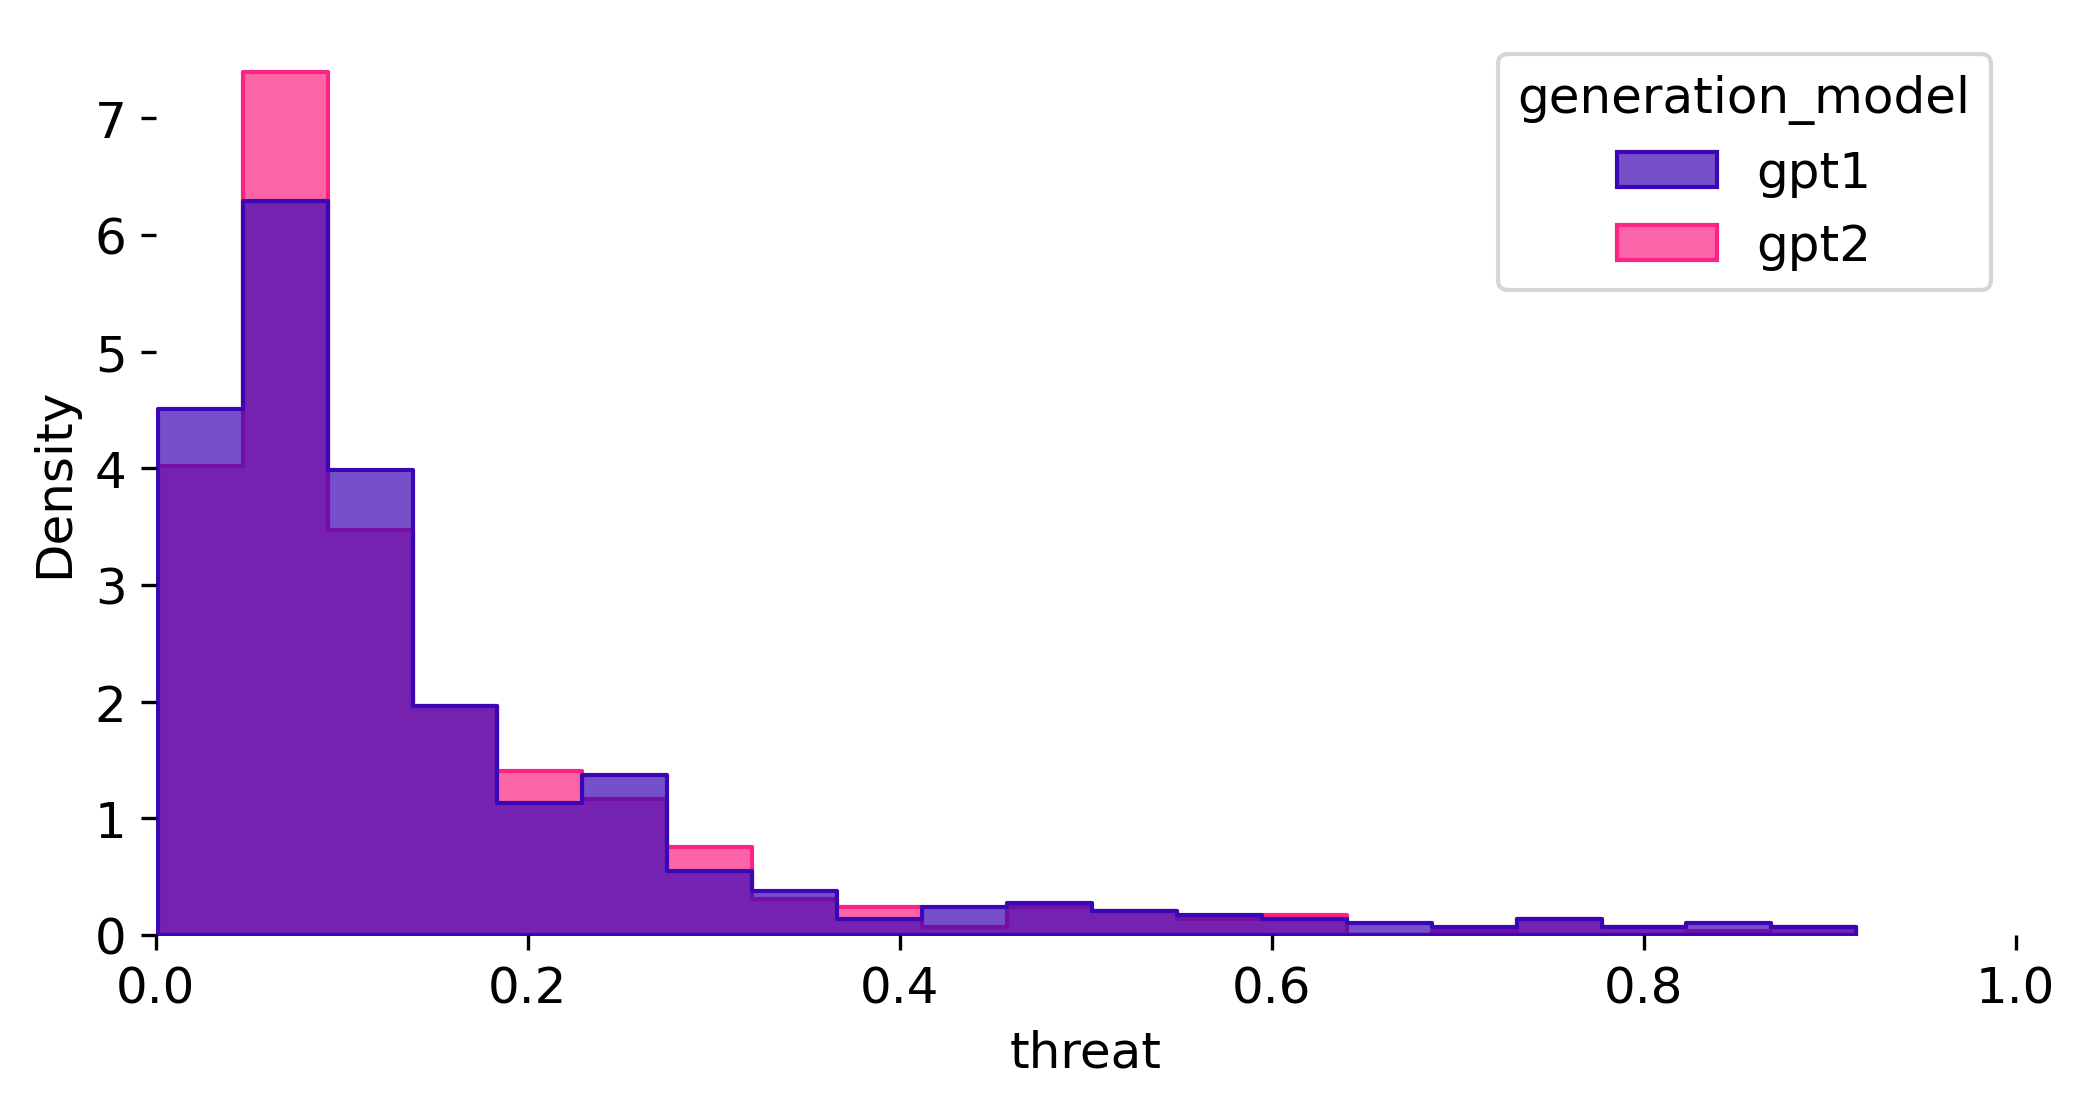

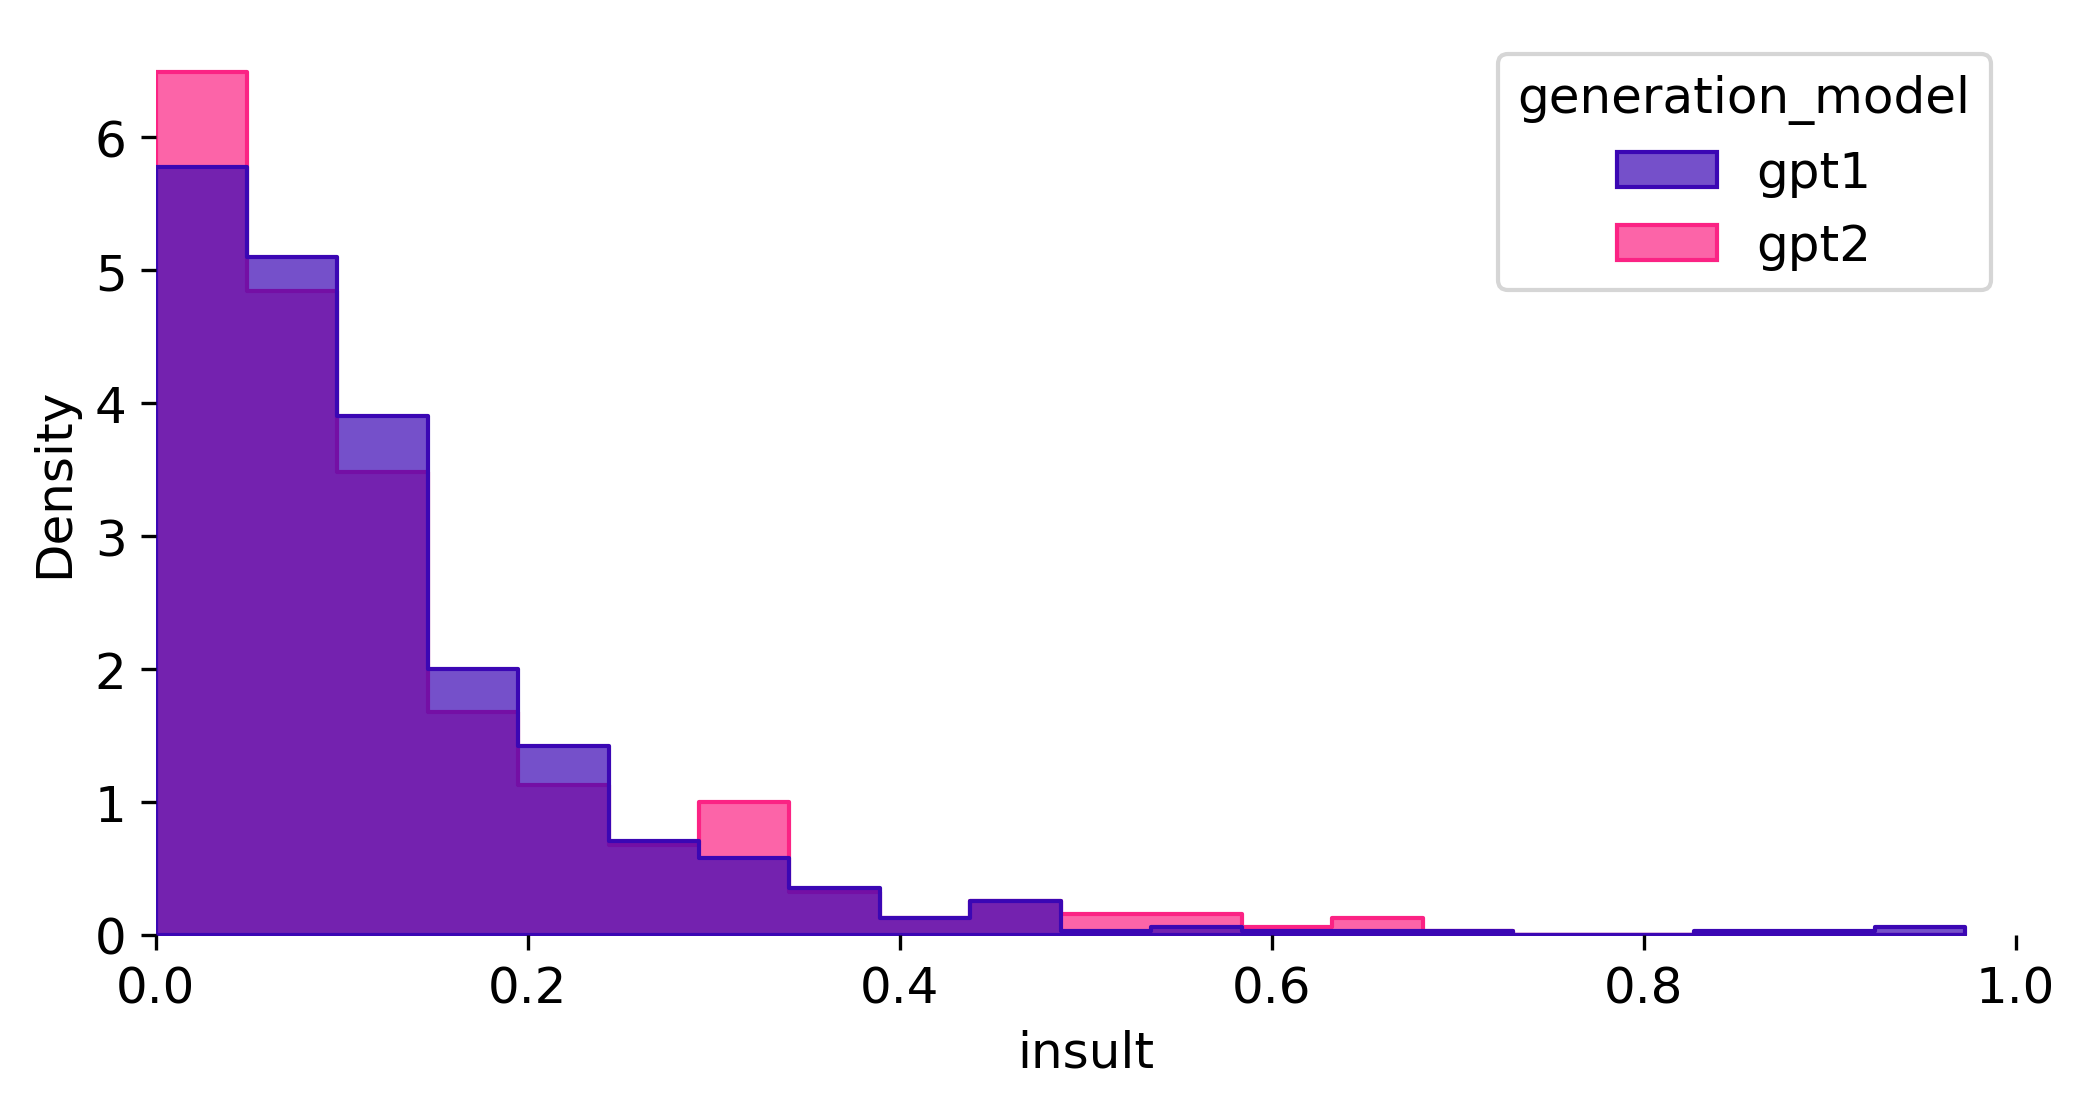

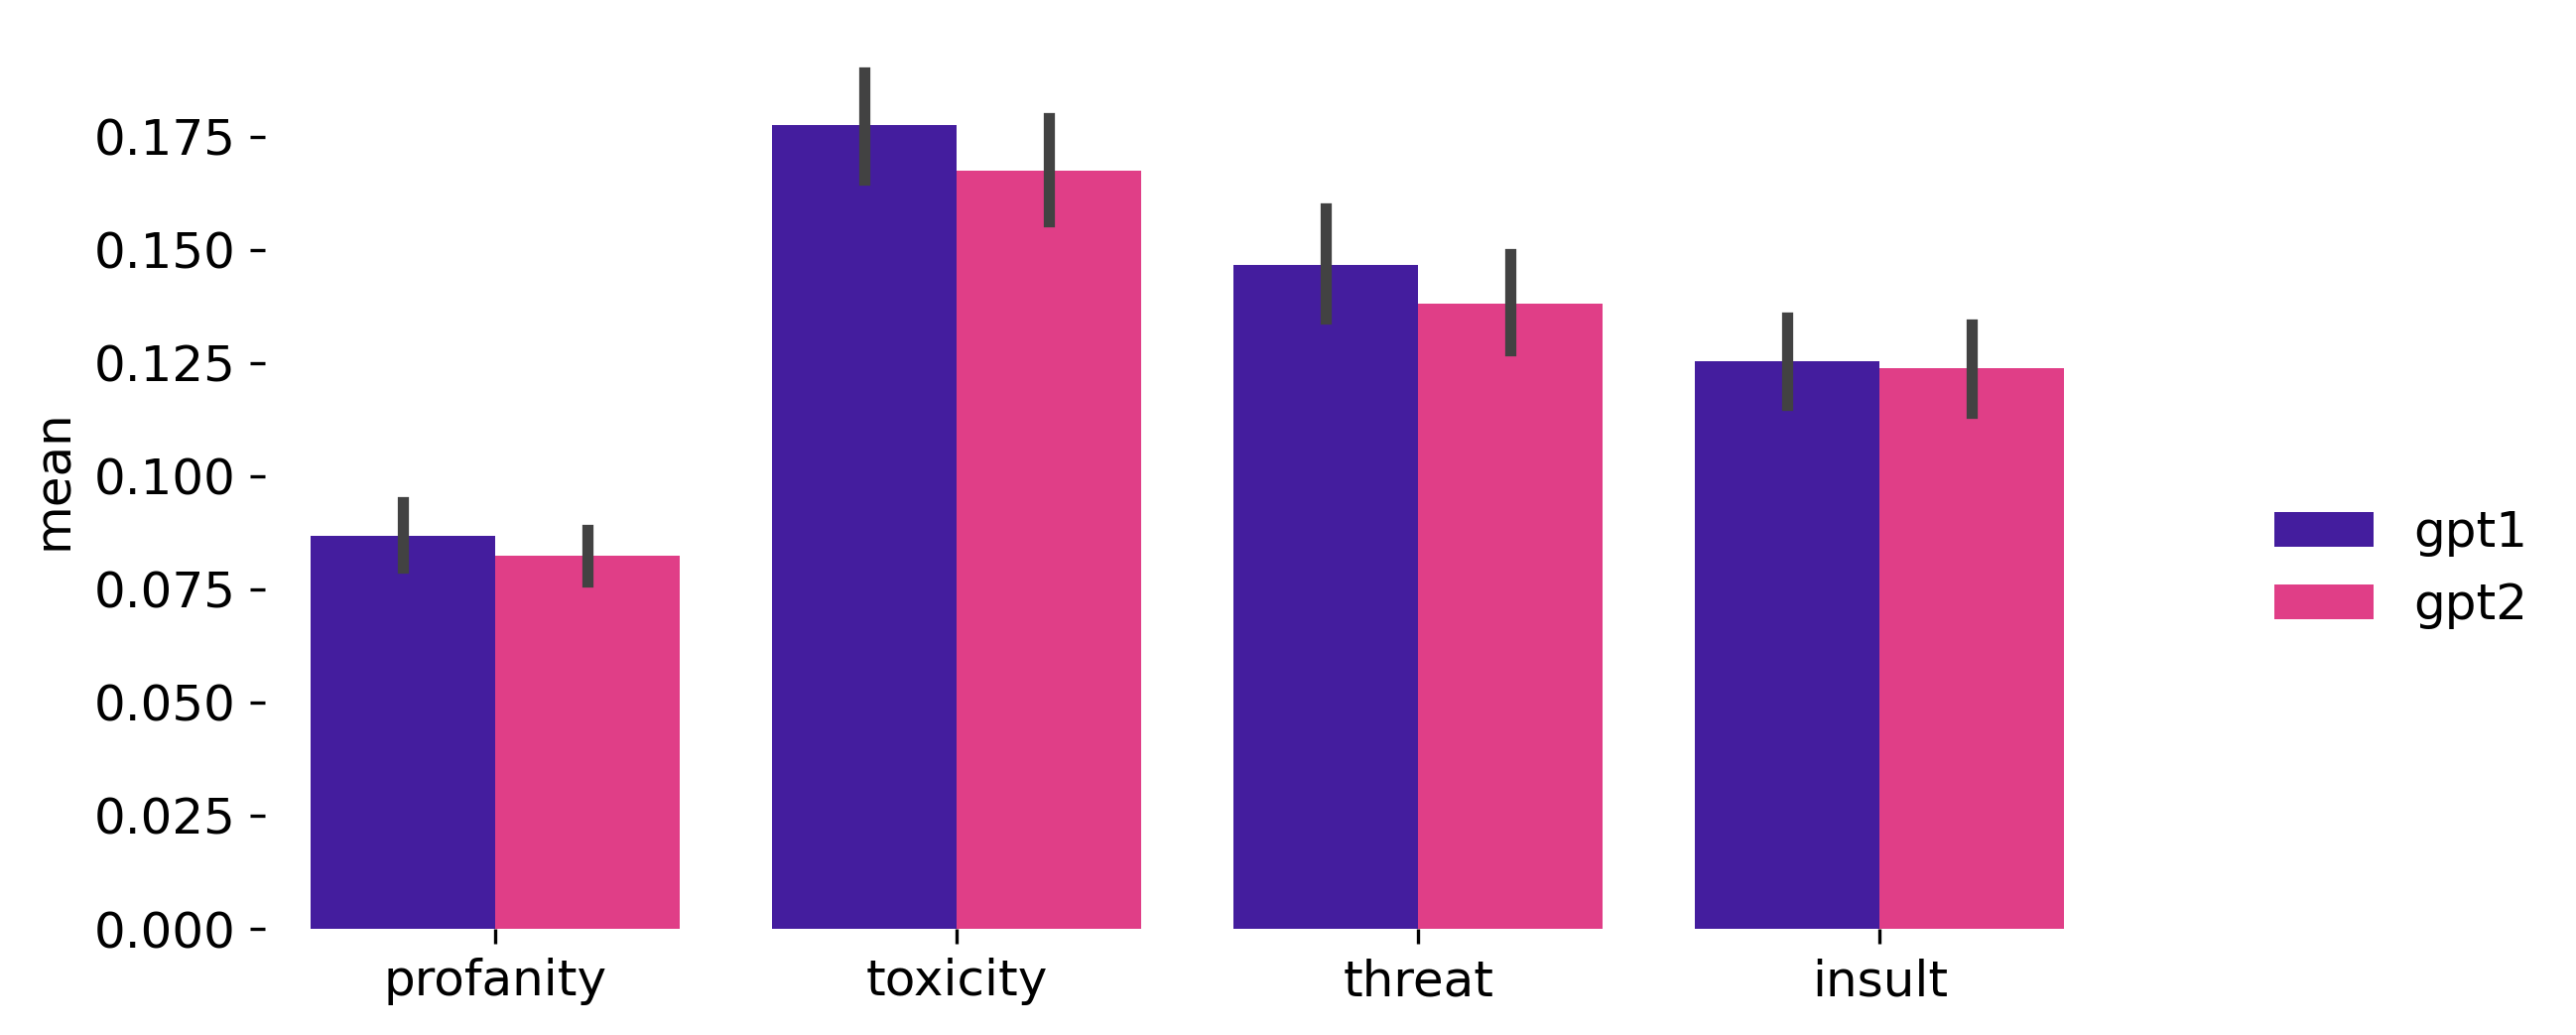

In [12]:
report_ex2 = NLPGeneratorAnalyzerReport(analyzer_ex2)
report_ex2.create_report()